__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. The dec matrix is the weights to pass back an forth (I think), although it comes out of SmoothBatch first
1. We are assuming we can test on the second half (updates 10-19ish) since learning should be complete by then!
1. Scipy.optimize.minimize() runs many iters to fully minimize its cost function.  You can change it to run as many iters as you'd like, although AFAIK you won't know how many it takes to converge.  But this is still a good set up for FL.
1. Hmm minimize() is doing BFGS rn and not SGD... not sure if that matters really.  Could probably implement SGD on my own or find it.  BFGS is 2nd order but we don't have a lot of parameters, I don't think.  Plus we can (already have?) solved analytically for the Hessian.

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

In [2]:
from experiment_params import *
from simulations import *
import time
import pickle
from sklearn.decomposition import PCA

#import warnings
#warnings.filterwarnings("ignore")

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL']
num_participants = 14

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [4]:
'''
cond0_dict_list = [0]*num_participants
for idx in range(num_participants):
    cond0_dict_list[idx] = {'training':emgs_block1[keys[idx]][0,:,:], 'labels':refs_block1[keys[idx]][0,:,:]}

with open(path+cond0_filename, 'wb') as fp:
    pickle.dump(cond0_dict_list, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
init_decoders = [Ws_block1[keys[i]][:, 0, :, :] for i in range(num_participants)]
with open(path+all_decs_init_filename, 'wb') as fp:
    pickle.dump(init_decoders, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''
0

0

# Create Federated Set Up

In [67]:
class ModelBase:
    # Hard coded attributes --> SHARED FOR THE ENTIRE CLASS
    num_updates = 19
    cphs_starting_update = 10
    update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
    
    def __init__(self, ID, w, method, smoothbatch=False, verbose=False, PCA_comps=7, current_round=0):
        self.type = 'Base'  # This gets overwritten but is required for __repr__ below
        self.ID = ID
        self.w = w  # Linear regression weights AKA the decoder
        self.w_prev = copy.copy(w)
        self.dec_log = [w]
        self.local_error_log = []
        self.global_error_log = []
        self.personalized_error_log = []
        self.method = method
        self.current_round = current_round
        self.verbose = verbose
        self.smoothbatch = smoothbatch
        
        self.PCA_comps = PCA_comps
        self.pca_channel_default = 64  # When PCA_comps equals this, DONT DO PCA
        if w.shape!=(2, self.PCA_comps):
            print(f"Base Model: {self.type}: Overwrote the decoder: {w.shape} --> {(2, self.PCA_comps)}")
            self.w = np.random.rand(2, PCA_comps)
        
    def __repr__(self): 
        return f"{self.type}{self.ID}"
    
    def display_info(self): 
        return f"{self.type} model: {self.ID}\nCurrent Round: {self.current_round}\nTraining Method: {self.method}"

In [59]:
class TrainingMethods:
    # Different training approaches
    
    def train_eta_gradstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, PCA_comps):
        grad_cost = np.reshape(gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, Ne=PCA_comps),(2, PCA_comps))
        w_new = w - eta*grad_cost
        return w_new

    def train_eta_scipyminstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, D0, display_info, PCA_comps, full=False):
        # I turned off display_info because it's kind of annoying
        if full:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps))#, options={'disp': display_info})
        else:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), options={'maxiter':eta}) #'disp': display_info, 
        w_new = np.reshape(out.x,(2, PCA_comps))
        return w_new

In [60]:
class Server(ModelBase):
    def __init__(self, ID, D0, method, all_clients, smoothbatch=False, C=0.1, current_round=0, PCA_comps=7, verbose=False):
        super().__init__(ID, D0, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose)
        self.type = 'Server'
        self.num_avail_clients = 0
        self.available_clients_list = [0]*len(all_clients)
        self.num_chosen_clients = 0
        self.chosen_clients_lst = [0]*len(all_clients)
        self.all_clients = all_clients
        self.C = C  # Fraction of clients to use each round
        
        # Overwrite init dec since 2,64 isn't compatible with compressed PCA compressed dec
        if w.shape!=(2, self.PCA_comps):
            print(f"Server Class: Overwrote Init Dec: {w.shape} --> {(2, self.PCA_comps)}")
            self.w = np.random.rand(2, PCA_comps)
            self.w_prev = np.random.rand(2, PCA_comps)
        
    # 0: Main Loop
    def execute_FL_loop(self):
        # Update global round number
        self.current_round += 1
        
        if self.method=='FedAvg':
            #print('FedAvg')
            # Choose fraction C of available clients
            self.set_available_clients_list()
            self.choose_clients()
            # Send those clients the current global model
            for my_client in self.chosen_clients_lst:
                my_client.global_w = self.w
            # Let those clients train (this autoselects the chosen_client_lst to use)
            self.train_client_and_log(client_set=self.chosen_clients_lst)
            # AGGREGATION
            self.w_prev = copy.copy(self.w)
            self.agg_local_weights()  # This func sets self.w, eg the new decoder
            # GLOBAL SmoothBatch
            if self.smoothbatch!=0:
                #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
                self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
        elif self.method=='NoFL':
            self.train_client_and_log(client_set=self.all_clients)
        else:
            print('Method not currently supported')
            print('Please reset method to FedAvg')
        # Save the new decoder to the log
        self.dec_log.append(self.w)
        
    # 1.1
    def set_available_clients_list(self):
        self.num_avail_clients = 0
        self.available_clients_list = [0]*len(self.all_clients)
        for idx, my_client in enumerate(self.all_clients):
            if my_client.availability:
                self.available_clients_list[idx] = my_client
                self.num_avail_clients += 1
    
    # 1.2
    def choose_clients(self):
        # First reset all clients to be not chosen
        for my_client in self.all_clients:
            my_client.reset_chosen()
        # Then check what client are available this round
        self.set_available_clients_list()
        # Now choose frac C clients from the resulting available clients
        if self.num_avail_clients > 0:
            self.num_chosen_clients = int(np.ceil(self.num_avail_clients*self.C))
            # Right now it chooses 2 at random: 14*.1=1.4 --> 2
            self.chosen_clients_lst = random.sample(self.available_clients_list, len(self.available_clients_list))[:self.num_chosen_clients]
            for my_client in self.chosen_clients_lst:
                my_client.chosen_status = 1
        else:
            print(f"ERROR: Number of available clients must be greater than 0: {self.num_avail_clients}")
        
    # 2
    def train_client_and_log(self, client_set):
        current_local_lst = []
        current_global_lst = []
        for my_client in client_set:
            if self.method != 'NoFL':
                # Pass down the global METHOD (NOT THE WEIGHTS!!)
                # Why am I passing this down lol... and why is this conditional...
                my_client.global_method = self.method
            my_client.execute_training_loop()
            current_local_lst.append((my_client.ID, my_client.eval_model(which='local')))
            if self.method != 'NoFL':
                current_global_lst.append((my_client.ID, my_client.eval_model(which='global')))
        self.local_error_log.append(current_local_lst)
        if self.method != 'NoFL':
            # NoFL case has no global model since there's no FL
            self.global_error_log.append(current_global_lst)
    
    # 3
    def agg_local_weights(self):
        # From McMahan 2017 (vanilla FL)
        summed_num_datapoints = 0
        for my_client in self.chosen_clients_lst:
            summed_num_datapoints += my_client.learning_batch
        # Aggregate local model weights, weighted by normalized local learning rate
        aggr_w = 0
        for my_client in self.chosen_clients_lst:
            aggr_w += (my_client.learning_batch/summed_num_datapoints) * my_client.w
        self.w = aggr_w
        # Still not clear how the global decoder will be able to adapt to different channels for different orientations

In [61]:
class Client(ModelBase, TrainingMethods):
    def __init__(self, ID, w, method, local_data, data_stream, smoothbatch=True, current_round=0, PCA_comps=7, availability=1, global_method='FedAvg', eta=1, num_steps=1, delay_scaling=5, random_delays=False, download_delay=1, upload_delay=1, local_round_threshold=250, condition_number=0, verbose=False):
        super().__init__(ID, w, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose)
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        # Sentinel Values
        self.F = None
        self.V = None
        self.D = None
        self.H = np.zeros((2,2))
        self.learning_batch = None
        self.dt = 1.0/60.0
        self.eta = eta
        self.training_data = local_data['training']
        self.labels = local_data['labels']
        
        # FL CLASS STUFF
        # Overwrite init dec since 2,64 isn't compatible with compressed PCA compressed dec
        if w.shape!=(2, self.PCA_comps):
            print(f"Client Class: Overwrote Init Dec: {w.shape} --> {(2, self.PCA_comps)}")
            self.w = np.random.rand(2, PCA_comps)
            self.w_prev = np.random.rand(2, PCA_comps)
            
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection: {Ignore updates and use all the data; Stream each update, moving to the next update after local_round_threshold iters have been run; After 1 iteration, move to the next update}
        self.data_stream = data_stream  # {'full_data', 'streaming', 'advance_each_iter'} 
        # Number of gradient steps to take when training (eg amount of local computation)
        self.num_steps = num_steps
        # GLOBAL STUFF
        self.global_w = None
        self.global_method = global_method
        # UPDATE STUFF
        if self.global_method=='NoFL':
            starting_update = 0
        else:
            starting_update = self.cphs_starting_update
        self.current_update = starting_update
        self.local_round_threshold = local_round_threshold
        self.current_threshold = local_round_threshold
        
        # Not even using the delay stuff right now
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        
        # ML Parameters / Conditions
        # This should probably be a dictionary at some point
        if condition_number==0:
            self.lr = 0.25
            self.alphaF = 1e-7
            self.alphaD = 1e-3
        else:
            print("That condition number is not yet supported")
         
    # 0: Main Loop
    def execute_training_loop(self):
        self.simulate_data_stream()
        self.train_model()
        self.eval_model(which='local')
        if self.global_method!="NoFL":
            self.eval_model(which='global')
        
    def simulate_delay(self, incoming):
        if incoming:
            time.sleep(self.download_delay+random.random())
        else:
            time.sleep(self.upload_delay+random.random())
            
    def simulate_data_stream(self):
        self.current_round += 1
        if self.current_update==17:
            #print("Maxxed out your update, continuing training on last update")
            # This is the max it can be before it breaks the bounds
            # Leave everything alone
            # Probably ought to track that we maxed out
            lower_bound = update_ix[0]
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='full_data':
            #print("FULL")
            lower_bound = update_ix[0]
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='streaming':
            #print("STREAMING")
            if self.current_round >= self.current_threshold:
                # This had weird behaviour, error increased after first two updates...
                #self.current_threshold += self.local_round_threshold
                self.current_threshold += self.current_threshold
                self.current_update += 1
                if self.verbose==True and self.ID==1:
                    print(f"New update after lrt passed: (new update, current round): {self.current_update, self.current_round}")
                    print()
            lower_bound = update_ix[self.current_update]
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='advance_each_iter':
            #print("ADVANCE")
            lower_bound = update_ix[self.current_update]
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
            self.current_update += 1
        else:
            raise ValueError('This data streaming functionality is not supported')
            
        s_temp = self.training_data[lower_bound:upper_bound,:]
        # Eg we need to do PCA since it is not equal to 64 channels
        if self.PCA_comps!=self.pca_channel_default:
            pca = PCA(n_components=self.PCA_comps)
            s_temp = pca.fit_transform(s_temp)
        s = np.transpose(s_temp)
        v_actual = self.w@s
        p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
        p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
        
        self.F = s[:,:-1] # note: truncate F for estimate_decoder
        self.V = (p_reference - p_actual)*self.dt
        self.D = copy.copy(self.w)
        self.H = np.zeros((2,2))
    
    def train_model(self):
        D_0 = self.w_prev
        # Set the w_prev equal to the current w:
        self.w_prev = copy.copy(self.w)
        if self.global_method!="NoFL":
            # Overwrite local model with the new global model
            self.w = self.global_w
        for i in range(self.num_steps):
            if self.method=='EtaGradStep':
                self.w = self.train_eta_gradstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, PCA_comps=self.PCA_comps)
            elif self.method=='EtaScipyMinStep':
                self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps)
            elif self.method=='FullScipyMinStep':
                self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps, full=True)
            else:
                print("Unrecognized method")
        # Do SmoothBatch
        if self.smoothbatch!=0:
                #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
                self.w = self.lr*self.w + ((1 - self.lr)*self.w_prev)
        # Save the new decoder to the log
        self.dec_log.append(self.w)
    
    def reset_chosen(self):
        self.chosen_status = 0
        
    def eval_model(self, which):
        if which=='local':
            my_dec = self.w
            my_error_log = self.local_error_log
        elif which=='global':
            my_dec = self.global_w
            my_error_log = self.global_error_log
        else:
            print("Please set <which> to either local or global")
        # This line is why all costs are integers... could try and change it to 2 decimal points but I've heard that frequently doesn't work
        # Just did this so we wouldn't have the 14 decimals points it always tries to give
        #temp = np.ceil(cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD))
        # I don't think I actually need it as an int? This is just to work around overflow errors
        # Generally ints cheaper than floats...
        #out = int(temp)
        temp = cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
        out = round(temp, 3)
        my_error_log.append(out)
        return out
        
    def test_inference(self):
        # Essentially, choose a random(?) section of data and compare how dec performs
        # Is this really any different from the eval funcs?
        
        # Would this be generating a new decoder to test on provided data, or just testing the current decoder on it?
        print("Testing Functionality Not Written Yet")
        pass

In [62]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

#pca = PCA(n_components=7)
#new_dec = pca.fit_transform(cond0_init_decs[0])
#print(new_dec.shape)
# Can't do this since 7 < min (2, 64)...

In [10]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

> __Passing in init decoders that are not (2, PCA_comps) AKA (2, 7) will result in the passed in dec getting overwritten to prevent matrix size mismatches.  Can't pass in the init dec from CPHS now because of PCA (unless you turn PCA off of course)__.

Check streaming condition

In [11]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', smoothbatch=True, delay_scaling=0) for i in range(14)]
global_model = Server(-100, D_0_7, 'FedAvg', user_c0_etascipy_streaming)

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec


In [12]:
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)

(1, 0, 10)
(2, 0, 10)
(3, 0, 10)

Global Error Log
[[(4, 2.138), (11, 11.696)], [(6, 8.266), (10, 0.469)], [(8, 4.086), (7, 5.072)]]

Local Error Log
[[(4, 0.971), (11, 6.938)], [(6, 9.756), (10, 0.425)], [(8, 8.239), (7, 4.562)]]


Check full data condition

In [13]:
user_c0_etascipy_full = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'full_data', smoothbatch=True, delay_scaling=0) for i in range(14)]
global_model = Server(-101, D_0_7, 'FedAvg', user_c0_etascipy_full)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
(1, 0, 10)
(2, 1, 10)
(3, 1, 10)

Global Error Log
[[(13, 540.582), (12, 58.406)], [(0, 188.943), (4, 39.565)], [(2, 67.82), (11, 207.538)]]

Local Error Log
[[(13, 399.66), (12, 82.15)], [(0, 226.146), (4, 48.251)], [(2, 67.116), (11, 226.539)]]


Check advance_each_iter condition

In [14]:
user_c0_etascipy_advance = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', smoothbatch=True, delay_scaling=0) for i in range(14)]
global_model = Server(-102, D_0_7, 'FedAvg', user_c0_etascipy_advance)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
(1, 1, 11)
(2, 2, 12)
(3, 3, 13)

Global Error Log
[[(11, 7.419), (0, 3.058)], [(10, 0.683), (0, 19.835)], [(4, 1.423), (0, 6.19)]]

Local Error Log
[[(11, 10.689), (0, 3.992)], [(10, 0.674), (0, 12.093)], [(4, 1.542), (0, 4.47)]]


Check the non-PCA case now... this is no longer the default

In [15]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', smoothbatch=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model = Server(-103, D_0_7, 'FedAvg', user_c0_etascipy_streaming, PCA_comps=64)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)
print()
print("Confirmation that no PCA happened (size should be 64)")
print(user_c0_etascipy_streaming[0].w.shape)
print(user_c0_etascipy_streaming[0].w_prev.shape)

(1, 1, 10)
(2, 1, 10)
(3, 1, 10)

Global Error Log
[[(13, 1722.586), (0, 989.732)], [(7, 6.493), (3, 208.601)], [(6, 6.523), (9, 1.042)]]

Local Error Log
[[(13, 14.43), (0, 4.67)], [(7, 6.465), (3, 207.684)], [(6, 6.478), (9, 1.039)]]

Confirmation that no PCA happened (size should be 64)
(2, 64)
(2, 64)


## Double Checking Running the No-FL Case
> We should see some kind of convergence
> TURNING PCA OFF FOR THIS CASE SINCE SIMS DID NOT HAVE IT

In [16]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', smoothbatch=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl = Server(-1, D_0_7, 'NoFL', user_c0_fullscipy, PCA_comps=64)
print("Global Round")
print(global_model_no_fl.current_round)
print()
print("Local Round")
print(user_c0_fullscipy[0].current_round)
print(user_c0_fullscipy[0].current_update)

Global Round
0

Local Round
0
0


In [17]:
global_model_no_fl.execute_FL_loop()

print("Global Round")
print(global_model_no_fl.current_round)
print()
print("Local Round")
print(user_c0_fullscipy[0].current_round)
print(user_c0_fullscipy[0].current_update)

Global Round
1

Local Round
1
1


In [18]:
# We are at update 2/19.  Therefore 19-2=17-1=16
num_updates_left = 16
for i in range(num_updates_left):
    if i%np.ceil(num_updates_left*.1)==0:
        print(f"Iter {i}")
    global_model_no_fl.execute_FL_loop()
print("Complete")
print()
print()
print()
print("Global Round")
print(global_model_no_fl.current_round)
print()
print("Local Round")
print(user_c0_fullscipy[0].current_round)
print(user_c0_fullscipy[0].current_update)

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Complete



Global Round
17

Local Round
17
17


In [19]:
print(user_c0_fullscipy[0].current_round)
print(user_c0_fullscipy[0].current_update)

17
17


Check the performance... should approximately mirror the previous NB, or at least show that error is decreasing...
> (3: darkorange), (13: deeppink), (1: maroon)

In [20]:
cost_array = np.zeros((num_participants,17))

for i in range(17):
    for (client_id, error) in global_model_no_fl.local_error_log[i]:
        #plt.scatter(i, error, color=id2color[client_id])
        cost_array[client_id, i] = error

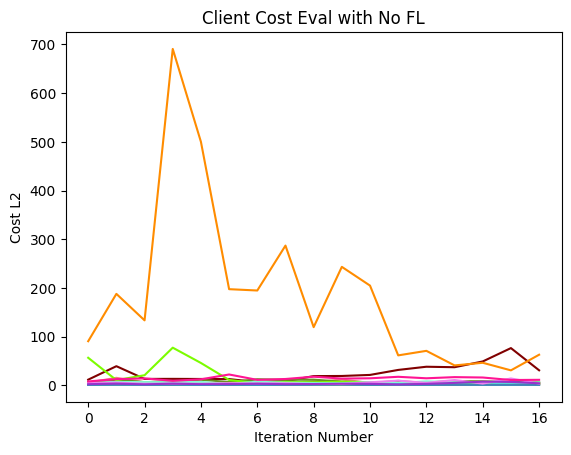

In [21]:
step_indices = list(range(17))
for i in range(num_participants):
    plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
plt.show()

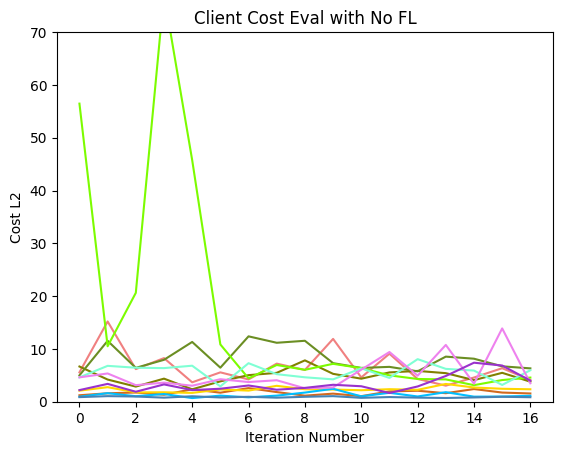

In [22]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
plt.ylim(0, 70)
plt.show()

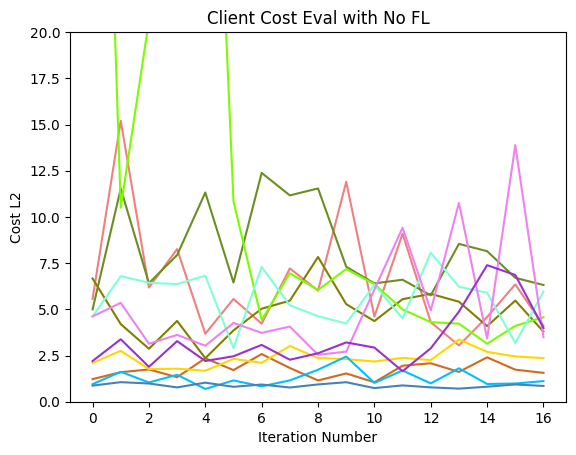

In [23]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
plt.ylim(0, 20)
plt.show()

Save Decs to compare to sims

In [24]:
all_user_decs_no_fl = [user_c0_fullscipy[i].dec_log for i in range(num_participants)]

#with open(path+nofl_decs_filename, 'wb') as fp:
#    pickle.dump(all_user_decs_no_fl, fp, protocol=pickle.HIGHEST_PROTOCOL)

## 1 Scipy Step, 1000 Iterations

In [25]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', smoothbatch=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_1scipystep.execute_FL_loop()
print("Complete")

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Iter 0
Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Iter 600
Iter 700
Iter 800
Iter 900
Complete


In [26]:
user_c0_1ScipyStep[1].current_round

145

In [27]:
user_c0_fullscipy[0].dec_log[2].shape

(2, 64)

Client1 only has 135 iterations because a random fraction (2 clients of 14) each iteration, so instead of each client having 1000 iters, they have some random fraction (presumably on average about 200, or 20% or 1000)

In [28]:
user_c0_1ScipyStep[1].current_update

10

In [29]:
for i in range(14):
    print((user_c0_1ScipyStep[i].current_round, user_c0_1ScipyStep[i].current_update))

(130, 10)
(145, 10)
(119, 10)
(144, 10)
(130, 10)
(151, 10)
(134, 10)
(131, 10)
(154, 10)
(156, 10)
(145, 10)
(135, 10)
(168, 10)
(158, 10)


It never advances the update (eg it starts at update 10).  We can see that 1000 global iters corresponds to about 140 local iters (why 140 and not 200?).  140 iters is just over halfway to the current threshold of 250 iters, although it clearly appears to be way too many iters since it appears to converge in like 10 iters (I guess that's local iters though).  Therefore, to get through all 9 remaining updates, we could either do (at least) 9 times (probably 18 times) as many iters, or just change the threshold to be like 100 or something. I'll take the latter approach below these graphs

Local
> Probably really ought to find a way to dynamically scale the number of datapoints I'm actually plotting... some kind of smoothing function so it doesn't take so long lol

Iter 0
Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Iter 600
Iter 700
Iter 800
Iter 900


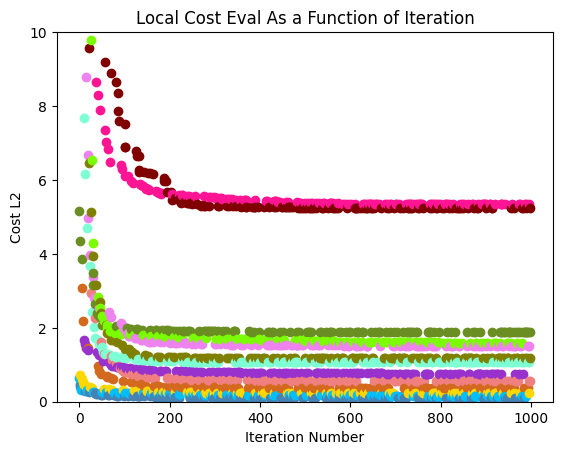

In [30]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model_1scipystep.local_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.ylim(0, 10)
plt.show()

Global

Iter 0
Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Iter 600
Iter 700
Iter 800
Iter 900


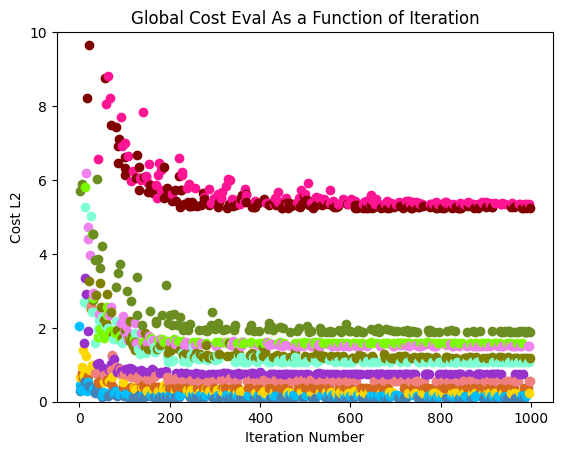

In [31]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model_1scipystep.global_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.ylim(0, 10)
plt.show()

__Redoing but setting the local threshold for update to be much lower__

Original code... before ending error got arbitrarily bad...

In [32]:
#user_c0_1ScipyStep = [Client(i, cond0_init_decs[i], 'EtaScipyMinStep', cond0_dict_list[i], 'streaming',  local_round_threshold=50, PCA_comps=7, smoothbatch=True, delay_scaling=0, verbose=True) for i in range(14)]
#global_model1 = Server(1, D_0, 'FedAvg', user_c0_1ScipyStep, PCA_comps=7)

The call I made is essentialy the same so it must've been something in the code itself that changed this...
> Could be because of more updates? Revert bug fix for doubling update number?

In [33]:
reduced_limit = 50

In [34]:
user_c0_1ScipyStep_lim50 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, smoothbatch=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim50 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim50)

big_loop_iters = 5000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_1scipystep_lim50.execute_FL_loop()
print("Complete")

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Iter 0
New update after lrt passed: (new update, current round): (11, 50)

Iter 500
New update after lrt passed: (new update, current round): (12, 100)

Iter 1000
New update after lrt passed: (new update, current round): (13, 200)

Iter 1500
Iter 2000
Iter 2500
New update after lrt passed: (new update, current round): (14, 400)

Iter 3000
Iter 3500
Iter 4000
Iter 4500
Complete


Local

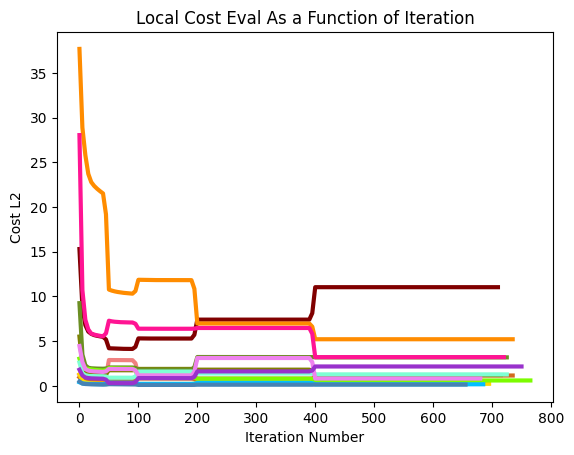

In [35]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    my_indices = np.array(range(len(df10.values)))*(dim_reduc_factor//2)
    plt.plot(my_indices, df10.values, color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

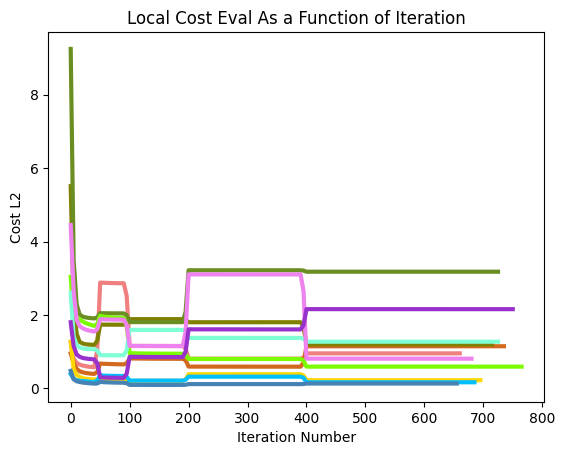

In [36]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].local_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        my_indices = np.array(range(len(df10.values)))*(dim_reduc_factor//2)
        plt.plot(my_indices, df10.values, color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

> From earlier run... not sure what changed... 
__Final update cost goes down__
1. 3 darkorange
1. 4 gold
1. 5 olive
1. 6 olivedrab, hardly
1. 7 lawngreen
1. 8 aquamarine
1. 9 deepskyblue
1. 11 violet
<br> <br> 
__Final update cost goes up__
1. 0 lightcoral
1. 1 maroon 
1. 2 chocolate
1. 10 steelblue
1. 12 darkorchid
1. 13 deeppink

Global

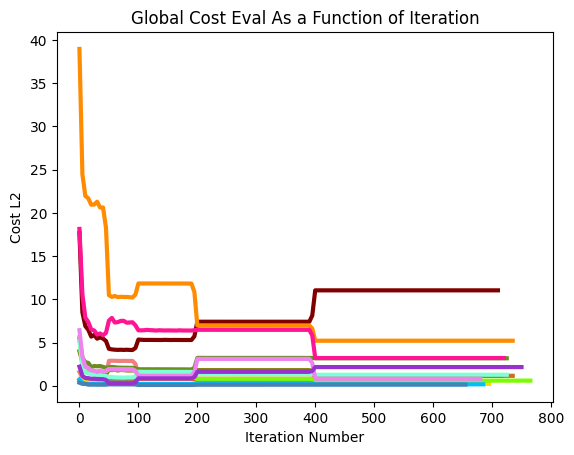

In [37]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    my_indices = np.array(range(len(df10.values)))*(dim_reduc_factor//2)
    plt.plot(my_indices, df10.values, color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

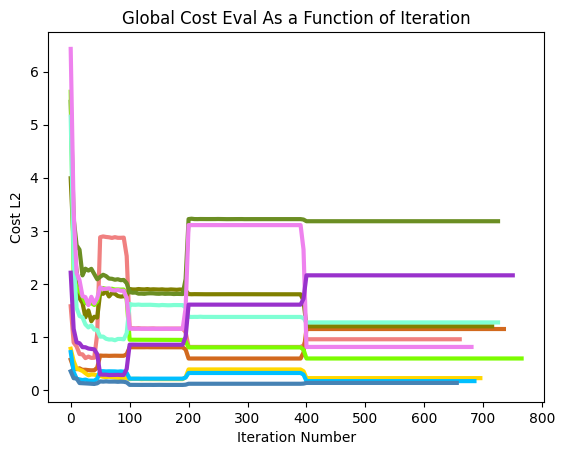

In [38]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].global_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        my_indices = np.array(range(len(df10.values)))*(dim_reduc_factor//2)
        plt.plot(my_indices, df10.values, color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

This time, use the final global model as the init instead of a random init
> Compare against using the local model? Doesn't help for new clients...

In [63]:
global_model_1scipystep_lim50.w

array([[-0.00021799, -0.00317384,  0.00343557,  0.00242676, -0.0001857 ,
         0.00028787, -0.00206755],
       [ 0.00030514, -0.00150376, -0.00081512,  0.00176174, -0.00244817,
         0.00033584, -0.00376249]])

In [64]:
user_c0_1ScipyStep_globaldec = [Client(i, global_model_1scipystep_lim50.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, smoothbatch=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_globaldecinit = Server(1, global_model_1scipystep_lim50.w, 'FedAvg', user_c0_1ScipyStep_globaldec)

big_loop_iters = 5000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_globaldecinit.execute_FL_loop()
print("Complete")

Base Model: Overwrote the decoder
Iter 0
New update after lrt passed: (new update, current round): (11, 50)

Iter 500
New update after lrt passed: (new update, current round): (12, 100)

Iter 1000
New update after lrt passed: (new update, current round): (13, 200)

Iter 1500
Iter 2000
Iter 2500
New update after lrt passed: (new update, current round): (14, 400)

Iter 3000
Iter 3500
Iter 4000
Iter 4500
Complete


Local

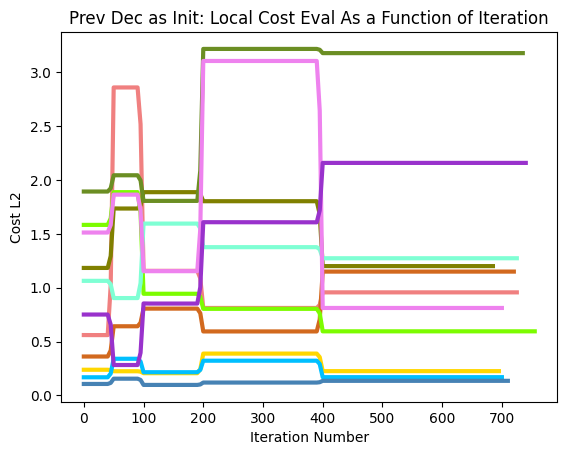

In [65]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].local_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        my_indices = np.array(range(len(df10.values)))*(dim_reduc_factor//2)
        plt.plot(my_indices, df10.values, color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Local Cost Eval As a Function of Iteration')
plt.show()

Global

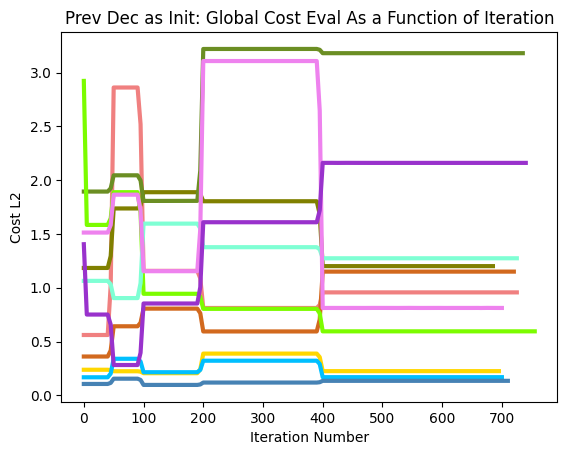

In [66]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].global_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        my_indices = np.array(range(len(df10.values)))*(dim_reduc_factor//2)
        plt.plot(my_indices, df10.values, color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Global Cost Eval As a Function of Iteration')
plt.show()

I can't tell much difference between the sets of plots, using the Previous Global Dec as the init...
<br> <br>
It overwrote it! But why?

## 10 Steps

In [43]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, smoothbatch=True, delay_scaling=0) for i in range(14)]
global_model2 = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model2.execute_FL_loop()
print("Complete")

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Iter 0
Iter 500
Iter 1000
Iter 1500
Iter 2000
Iter 2500
Iter 3000
Iter 3500
Iter 4000
Iter 4500
Complete


## Varying Eta

1. C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
    - return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
1. C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
    - e = ( np.sum((D@F + H@Vminus - Vplus)\*\*2)\*(alphaE) #/ (Nd\*Nt)
1. C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
    - \+ alphaD\*np.sum(D\*\*2) #/ (Nd\*Ne)

In [44]:
user_c0_eta10 = [Client(i, D_0_7, 'EtaGradStep', cond0_training_and_labels_lst[i], 'streaming', eta=10, smoothbatch=True, delay_scaling=0) for i in range(14)]
global_model3 = Server(3, D_0_7, 'FedAvg', user_c0_eta10)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model3.execute_FL_loop()
print("Complete")

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Iter 0


C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

Iter 500


C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
  + alphaD*np.sum(D**2) #/ (Nd*Ne)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflo

C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:22: RuntimeWarning: invalid value encountered in matmul
  return ((2 * (D@F + H@Vminus - Vplus)@F.T*(alphaE) #/ (Nd*Nt) # They multiply F.T by lambdaE
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: invalid value encountered in matmul
  e = ( np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE) #/ (Nd*Nt)


Iter 1000
Iter 1500
Iter 2000
Iter 2500
Iter 3000
Iter 3500
Iter 4000
Iter 4500
Complete


In [45]:
user_c0_eta10[0].w

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [46]:
user_c0_eta10[0].D

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [47]:
user_c0_eta10[0].F

array([[-66.28066698, -66.28066698, -68.26360648, ...,  97.28275518,
         97.28275518,  97.28275518],
       [-18.78079055, -18.78079055, -20.04720378, ..., -45.96235158,
        -45.96235158, -45.96235158],
       [  6.33070373,   6.33070373,   5.4290475 , ...,  -8.46044513,
         -8.46044513,  -8.46044513],
       ...,
       [ 15.45495723,  15.45495723,   9.93326903, ...,  -0.90483476,
         -0.90483476,  -0.90483476],
       [ -0.84727995,  -0.84727995,  -1.63383969, ...,  18.8251075 ,
         18.8251075 ,  18.8251075 ],
       [  2.35498357,   2.35498357,  -0.34325676, ...,  -6.23995431,
         -6.23995431,  -6.23995431]])

## Full Scipy.Minimize

In [49]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', smoothbatch=True, delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy)

for i in range(18):
    if i%np.ceil(18*.1)==0:
        print(f"Iter {i}")
    global_model_fullscipy.execute_FL_loop()
print("Complete")

Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Overwrote Init Dec
Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Iter 16
Complete


Local

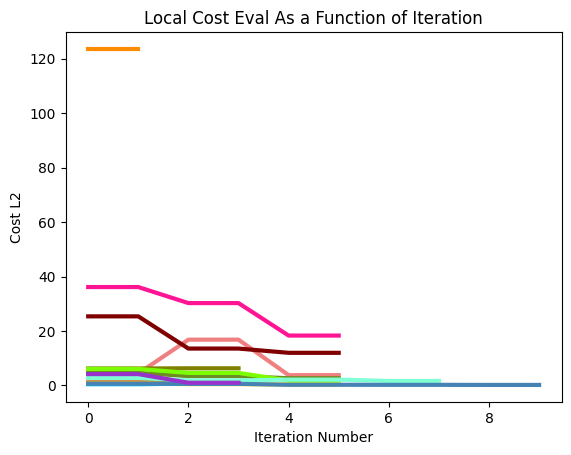

In [51]:
#dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].local_error_log)
    #df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    my_indices = np.array(range(len(df.values)))#10.values)))*(dim_reduc_factor//2)
    plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
           
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

Global

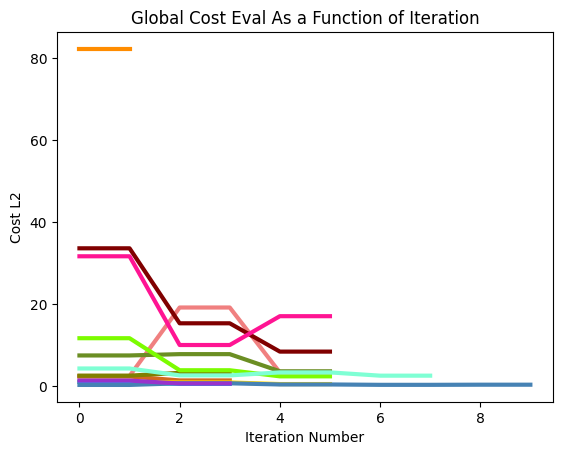

In [52]:
#dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].global_error_log)
    #df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    my_indices = np.array(range(len(df.values)))#10.values)))*(dim_reduc_factor//2)
    plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()